In [1]:
# 由于要实现的模型涉及到比较复杂的数据处理和分析，我们将从简单的数据探索开始，
# 然后尝试定义并计算动量指标，最后进行简单的可视化展示。
# 本例将重点放在如何根据比赛分数计算动量，并不会构建一个完整的状态空间模型。

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')
# 读取数据
df = pd.read_csv('Wimbledon_featured_matches.csv')

# 选择一场特定的比赛进行分析，根据题目描述选择2023年温布尔登决赛
# 假设决赛的match_id为"2023-wimbledon-1701"
match_id = "2023-wimbledon-1701"
match_data = df[df['match_id'] == match_id].copy()
match_data.reset_index(inplace=True,drop=True)

势头可以被定义为球员当前表现的一个量度，相对于比赛中平均或预期表现的偏差。整体定义思想是：动量可以通过计算球员在特定时间窗口内相对于对手的得分优势来量化。请基于上面提供的数据，定义一个势头计算函数，尽可能全部利用数据中的指标，用于计算球员1，2各种在特定特定时间窗口内的势头，需要注意，在网球比赛中，发球方赢得分数/局的概率较高，这一点可以在模型中得到体现。

为了定义一个计算网球比赛中球员势头的函数，我们可以考虑以下几个关键指标：

1. **得分优势**：比较特定时间窗口内两位球员的得分差异。
2. **赢得的局数和盘数**：在时间窗口内，比较两位球员各自赢得的局数和盘数，更高的数值表示更大的势头。
3. **发球情况**：在网球中，发球方有较大优势。我们可以考虑发球方赢得的分数比例，以及发球方是否能够保发（即赢得自己的发球局）。
4. **破发点**：破发点赢得数量也是势头的一个重要指标，它表示球员能够在对方发球局中赢得比赛的能力。
5. **非受迫性失误**：较少的非受迫性失误可以被看作是更好的表现和更高的势头。
6. **制胜分**：制胜分的数量可以表示球员的攻击力和比赛中的主动性。

基于以上指标，我们可以定义一个简单的势头计算模型，将以上各因素加权合并。发球方优势可以通过增加发球方在该时间窗口内赢得的分数/局的权重来体现。以下是一个简化版的势头计算函数的伪代码：


这个模型是一个起点，可以根据实际情况和更深入的数据分析进行调整和优化。例如，权重的选择和其他潜在指标的加入可以进一步细化模型，以更准确地反映比赛中的势头变化。

In [7]:
# 改进势头计算函数以包括赢得的局数和盘数，以及更精确的发球优势计算
def calculate_momentum_improved(df, index, window_size=3):
    start_index = max(index - window_size, 0)
    end_index = min(index + window_size + 1, len(df))
    time_window_df = df.iloc[start_index:end_index]

    # 初始化势头值
    p1_momentum = 0
    p2_momentum = 0

    # 赢得的局数和盘数
    p1_sets_won = time_window_df['p1_sets'].iloc[-1] - time_window_df['p1_sets'].iloc[0]
    p2_sets_won = time_window_df['p2_sets'].iloc[-1] - time_window_df['p2_sets'].iloc[0]
    p1_games_won = time_window_df['p1_games'].iloc[-1] - time_window_df['p1_games'].iloc[0]
    p2_games_won = time_window_df['p2_games'].iloc[-1] - time_window_df['p2_games'].iloc[0]

    # 发球优势
    # 假设发球方在每个得分上的额外权重为0.1
    serve_advantage_weight = 0.1
    p1_serve_advantage = (time_window_df[time_window_df['server'] == 1]['point_victor'] == 1).sum() * serve_advantage_weight
    p2_serve_advantage = (time_window_df[time_window_df['server'] == 2]['point_victor'] == 2).sum() * serve_advantage_weight

    # 其他因素（得分优势、破发点、非受迫性失误、制胜分）
    p1_points_advantage = time_window_df['point_victor'].apply(lambda x: x == 1).sum() - time_window_df['point_victor'].apply(lambda x: x == 2).sum()
    p2_points_advantage = -p1_points_advantage
    p1_break_points_won = time_window_df['p1_break_pt_won'].sum()
    p2_break_points_won = time_window_df['p2_break_pt_won'].sum()
    p1_unforced_errors = -time_window_df['p1_unf_err'].sum()
    p2_unforced_errors = -time_window_df['p2_unf_err'].sum()
    p1_winners = time_window_df['p1_winner'].sum()
    p2_winners = time_window_df['p2_winner'].sum()

    # 合并计算势头
    p1_momentum = p1_points_advantage + p1_serve_advantage + p1_break_points_won + p1_unforced_errors + p1_winners + p1_sets_won + p1_games_won
    #p2_momentum = p2_points_advantage + p2_serve_advantage + p2_break_points_won + p2_unforced_errors + p2_winners + p2_sets_won + p2_games_won

    return p1_points_advantage, p1_serve_advantage, p1_break_points_won, p1_unforced_errors, p1_winners , p1_sets_won, p1_games_won




# 对数据集中的每一行应用计算势头的函数
momentum_values = [calculate_momentum_improved(match_data, index) for index in range(len(match_data))]

# p1_points_advantage 对应 得分优势：表示球员1相对于球员2在特定时间窗口内的得分差异。
# p1_serve_advantage 对应 发球优势：量化了球员1作为发球方在得分上的额外优势。
# p1_break_points_won 对应 破发点：表示球员1在时间窗口内赢得的破发点数量，反映了球员在对方发球局中赢得比赛的能力。
# p1_unforced_errors 对应 非受迫性失误：通过时间窗口内非受迫性失误的总数（取负值）来衡量球员的失误率，较少的非受迫性失误表示更好的表现。
# p1_winners 对应 制胜分：球员1在时间窗口内制胜分的总数，表示攻击力和比赛中的主动性。
# p1_sets_won 对应 赢得的盘数：球员1在特定时间窗口内赢得的盘数。
# p1_games_won 对应 赢得的局数：球员1在特定时间窗口内赢得的局数。
player1_data=pd.DataFrame(momentum_values,columns=['p1_points_advantage','p1_serve_advantage',
                                     'p1_break_points_won','p1_unforced_errors',
                                     'p1_winners','p1_sets_won',
                                     'p1_games_won'])
pd.DataFrame(momentum_values,columns=['p1_points_advantage','p1_serve_advantage',
                                     'p1_break_points_won','p1_unforced_errors',
                                     'p1_winners','p1_sets_won',
                                     'p1_games_won']).to_csv('球员1势能.csv',index=None)


# 改进势头计算函数以包括赢得的局数和盘数，以及更精确的发球优势计算
def calculate_momentum_improved(df, index, window_size=3):
    start_index = max(index - window_size, 0)
    end_index = min(index + window_size + 1, len(df))
    time_window_df = df.iloc[start_index:end_index]

    # 初始化势头值
    p1_momentum = 0
    p2_momentum = 0

    # 赢得的局数和盘数
    p1_sets_won = time_window_df['p1_sets'].iloc[-1] - time_window_df['p1_sets'].iloc[0]
    p2_sets_won = time_window_df['p2_sets'].iloc[-1] - time_window_df['p2_sets'].iloc[0]
    p1_games_won = time_window_df['p1_games'].iloc[-1] - time_window_df['p1_games'].iloc[0]
    p2_games_won = time_window_df['p2_games'].iloc[-1] - time_window_df['p2_games'].iloc[0]

    # 发球优势
    # 假设发球方在每个得分上的额外权重为0.1
    serve_advantage_weight = 0.1
    p1_serve_advantage = (time_window_df[time_window_df['server'] == 1]['point_victor'] == 1).sum() * serve_advantage_weight
    p2_serve_advantage = (time_window_df[time_window_df['server'] == 2]['point_victor'] == 2).sum() * serve_advantage_weight

    # 其他因素（得分优势、破发点、非受迫性失误、制胜分）
    p1_points_advantage = time_window_df['point_victor'].apply(lambda x: x == 1).sum() - time_window_df['point_victor'].apply(lambda x: x == 2).sum()
    p2_points_advantage = -p1_points_advantage
    p1_break_points_won = time_window_df['p1_break_pt_won'].sum()
    p2_break_points_won = time_window_df['p2_break_pt_won'].sum()
    p1_unforced_errors = -time_window_df['p1_unf_err'].sum()
    p2_unforced_errors = -time_window_df['p2_unf_err'].sum()
    p1_winners = time_window_df['p1_winner'].sum()
    p2_winners = time_window_df['p2_winner'].sum()


    return p2_points_advantage, p2_serve_advantage, p2_break_points_won, p2_unforced_errors, p2_winners , p2_sets_won, p2_games_won




# 对数据集中的每一行应用计算势头的函数
momentum_values = [calculate_momentum_improved(match_data, index) for index in range(len(match_data))]

# p1_points_advantage 对应 得分优势：表示球员1相对于球员2在特定时间窗口内的得分差异。
# p1_serve_advantage 对应 发球优势：量化了球员1作为发球方在得分上的额外优势。
# p1_break_points_won 对应 破发点：表示球员1在时间窗口内赢得的破发点数量，反映了球员在对方发球局中赢得比赛的能力。
# p1_unforced_errors 对应 非受迫性失误：通过时间窗口内非受迫性失误的总数（取负值）来衡量球员的失误率，较少的非受迫性失误表示更好的表现。
# p1_winners 对应 制胜分：球员1在时间窗口内制胜分的总数，表示攻击力和比赛中的主动性。
# p1_sets_won 对应 赢得的盘数：球员1在特定时间窗口内赢得的盘数。
# p1_games_won 对应 赢得的局数：球员1在特定时间窗口内赢得的局数。
player2_data=pd.DataFrame(momentum_values,columns=['p2_points_advantage','p2_serve_advantage',
                                     'p2_break_points_won','p2_unforced_errors',
                                     'p2_winners','p2_sets_won',
                                     'p2_games_won'])
pd.DataFrame(momentum_values,columns=['p2_points_advantage','p2_serve_advantage',
                                     'p2_break_points_won','p2_unforced_errors',
                                     'p2_winners','p2_sets_won',
                                     'p2_games_won']).to_csv('球员2势能.csv',index=None)

In [8]:
import numpy as np

def entropy_weight_method(data):
    """
    熵权法计算各指标的权重
    :param data: DataFrame, 各指标的数据
    :return: 权重数组
    """
    # 数据标准化处理
    data_normalized = data.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
    
    # 计算每个指标的熵值
    epsilon = 1e-12  # 避免log(0)
    p_matrix = data_normalized / data_normalized.sum()
    e_matrix = -np.sum(p_matrix * np.log(p_matrix + epsilon), axis=0) / np.log(len(data))
    
    # 计算每个指标的差异系数
    d_matrix = 1 - e_matrix
    
    # 计算权重
    weights = d_matrix / d_matrix.sum()
    
    return weights

# 计算球员1和球员2的指标权重
weights_p1 = entropy_weight_method(player1_data)
weights_p2 = entropy_weight_method(player2_data)

# 打印权重
print("球员1各指标权重:\n", weights_p1)
print("\n球员2各指标权重:\n", weights_p2)

# 计算加权后的综合得分
player1_score = (player1_data * weights_p1).sum(axis=1)
player2_score = (player2_data * weights_p2).sum(axis=1)

# 将综合得分加入原数据中
player1_data['Composite Score'] = player1_score
player2_data['Composite Score'] = player2_score




球员1各指标权重:
 p1_points_advantage    0.009308
p1_serve_advantage     0.054697
p1_break_points_won    0.344077
p1_unforced_errors     0.020944
p1_winners             0.058447
p1_sets_won            0.507352
p1_games_won           0.005175
dtype: float64

球员2各指标权重:
 p2_points_advantage    0.019622
p2_serve_advantage     0.034886
p2_break_points_won    0.336197
p2_unforced_errors     0.007257
p2_winners             0.100169
p2_sets_won            0.495733
p2_games_won           0.006137
dtype: float64


In [9]:
# 将计算得到的势头值分配回原始数据集
match_data['p1_momentum']=pd.DataFrame(player1_data['Composite Score'])
match_data['p2_momentum']=pd.DataFrame(player2_data['Composite Score'])

In [10]:

# 显示更新后的数据集的前几行，包括势头值
match_data[['match_id', 'player1', 'player2', 'elapsed_time', 'p1_momentum', 'p2_momentum']].head()

,match_id,player1,player2,elapsed_time,p1_momentum,p2_momentum
0,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,00:00:00,0.058447,0.006977
1,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,00:00:25,0.067755,-0.019901
2,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,00:01:19,0.058447,0.003209
3,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,00:02:17,0.049139,0.126488
4,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,00:03:02,0.067755,0.083756


In [11]:
match_data[['match_id', 'player1', 'player2', 'elapsed_time', 'p1_momentum', 'p2_momentum']].to_csv('Q1_demo.csv',index=None)

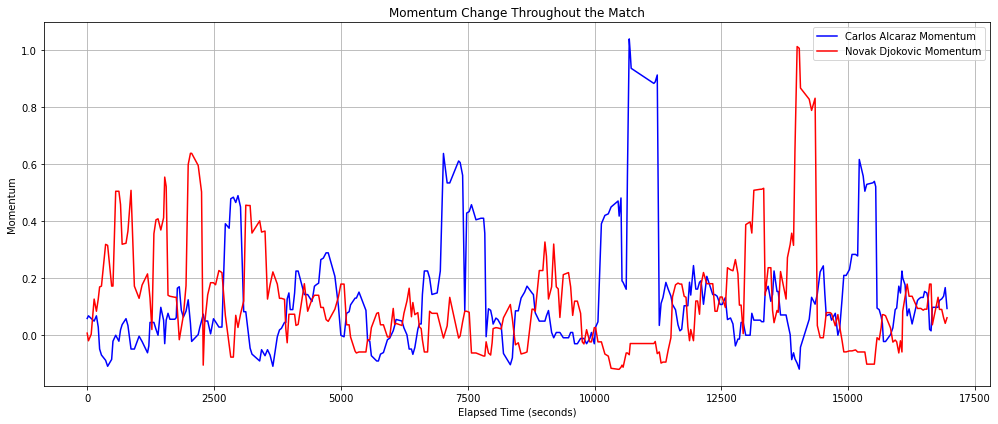

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# 将 elapsed_time 转换为可比较的数值（秒）
elapsed_seconds = match_data['elapsed_time'].apply(lambda x: sum(int(a) * 60**index for index, a in enumerate(reversed(x.split(":")))))

# 绘制势头变化图
plt.figure(figsize=(14, 6))

# 绘制球员1的势头变化
plt.plot(elapsed_seconds, match_data['p1_momentum'], label=match_data['player1'].iloc[0] + " Momentum", color='blue')
# 绘制球员2的势头变化
plt.plot(elapsed_seconds, match_data['p2_momentum'], label=match_data['player2'].iloc[0] + " Momentum", color='red')

# 添加图例
plt.legend()

# 设置标题和坐标轴标签
plt.title('Momentum Change Throughout the Match')
plt.xlabel('Elapsed Time (seconds)')
plt.ylabel('Momentum')

# 改善图表的可读性
plt.grid(True)
plt.tight_layout()

# 显示图表
plt.show()


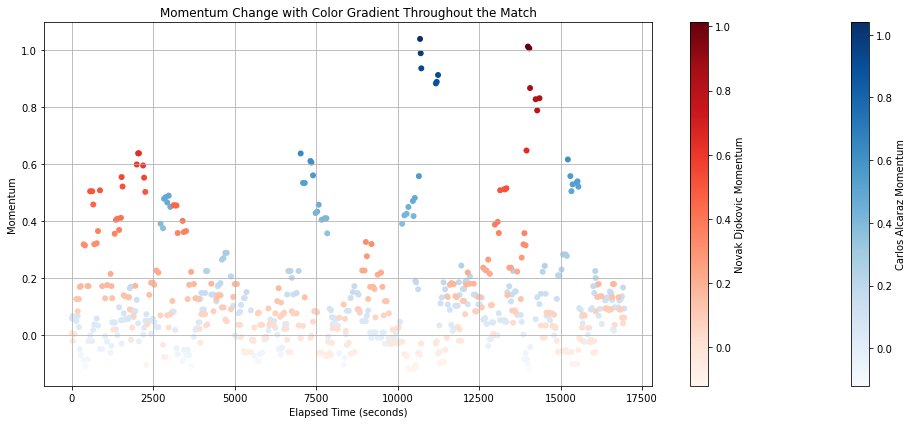

In [13]:
# 为了使用渐变色表示球员在特定时刻的优势程度，我们将使用散点图，其中点的颜色深浅表示势头的大小。

# 创建颜色映射
# 势头值范围
momentum_range = np.linspace(min(min(match_data['p1_momentum']), min(match_data['p2_momentum'])),
                             max(max(match_data['p1_momentum']), max(match_data['p2_momentum'])), num=100)
# 创建一个颜色映射对象
cmap = plt.get_cmap('coolwarm')

# 绘制势头变化图
plt.figure(figsize=(14, 6))

# 绘制球员1的势头变化
sc1 = plt.scatter(elapsed_seconds, match_data['p1_momentum'], c=match_data['p1_momentum'], cmap='Blues', label=match_data['player1'].iloc[0] + " Momentum", edgecolor='none')
# 绘制球员2的势头变化
sc2 = plt.scatter(elapsed_seconds, match_data['p2_momentum'], c=match_data['p2_momentum'], cmap='Reds', label=match_data['player2'].iloc[0] + " Momentum", edgecolor='none')

# 添加颜色条
cbar1 = plt.colorbar(sc1, orientation='vertical')
cbar2 = plt.colorbar(sc2, orientation='vertical')
cbar1.set_label(match_data['player1'].iloc[0] + ' Momentum')
cbar2.set_label(match_data['player2'].iloc[0] + ' Momentum')

# 设置标题和坐标轴标签
plt.title('Momentum Change with Color Gradient Throughout the Match')
plt.xlabel('Elapsed Time (seconds)')
plt.ylabel('Momentum')

# 显示图表
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
import matplotlib.pyplot as plt

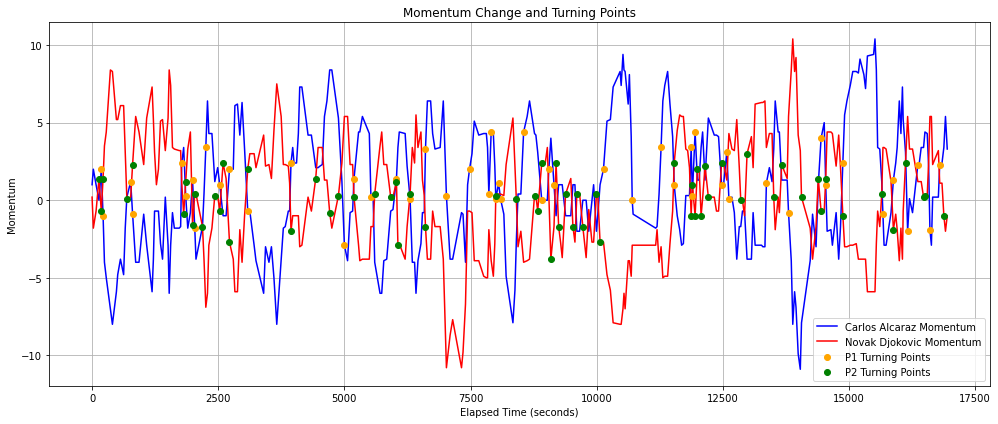

In [24]:
def cumsum_detection(series):
    """
    CUMSUM检测算法实现，用于检测序列中的转折点。
    :param series: 一维数据序列 (Pandas Series)
    :return: 转折点的索引列表
    """
    # 计算差分序列
    diff_series = series.diff().fillna(0)  # 用0填充NaN值
    
    # 计算累积和
    cumsum_series = diff_series.cumsum()
    
    # 识别转折点：当累积和重新穿过零点时，认为是一个转折点
    turning_points = []
    for i in range(1, len(cumsum_series)):
        # 如果累积和的符号与前一个不同，则认为是转折点
        if cumsum_series[i] * cumsum_series[i-1] < 0:
            turning_points.append(i)
    
    return turning_points

# 应用CUMSUM检测算法来识别两位球员势头的转折点
p1_turning_points = cumsum_detection(match_data['p1_momentum'])
p2_turning_points = cumsum_detection(match_data['p2_momentum'])

# 绘制势头变化和转折点
plt.figure(figsize=(14, 6))
plt.plot(elapsed_seconds, match_data['p1_momentum'], label=match_data['player1'].iloc[0] + " Momentum", color='blue')
plt.plot(elapsed_seconds, match_data['p2_momentum'], label=match_data['player2'].iloc[0] + " Momentum", color='red')

# 标记转折点
plt.scatter(elapsed_seconds.iloc[p1_turning_points], match_data['p1_momentum'].iloc[p1_turning_points], color='orange', label='P1 Turning Points', zorder=5)
plt.scatter(elapsed_seconds.iloc[p2_turning_points], match_data['p2_momentum'].iloc[p2_turning_points], color='green', label='P2 Turning Points', zorder=5)

plt.legend()
plt.title('Momentum Change and Turning Points')
plt.xlabel('Elapsed Time (seconds)')
plt.ylabel('Momentum')
plt.grid(True)
plt.tight_layout()
plt.show()



检测转折点，即比赛结果可能发生显著变化的关键球点，可以通过分析球员势头的变化来实现。一种方法是寻找势头变化的显著点，即从连续失分到连续得分的转变，或者反之。这可以通过检测势头时间序列中的变化点来实现。

在这里，我们可以使用差异性检验算法，比如CUMSUM（累积和）检测算法，来确定势头中的转折点。CUMSUM检测算法通过累积序列中的正负变化来识别潜在的转变点。以下是实现此算法的步骤：

1. **计算势头差分序列**：首先，我们需要计算每位球员势头的差分序列，即当前点的势头与前一点的势头之差。
2. **应用CUMSUM算法**：然后，对势头差分序列应用CUMSUM算法，寻找势头发生显著变化的点。
3. **识别转折点**：基于CUMSUM结果，我们可以确定哪些点是潜在的转折点，即比赛中势头发生显著变化的时刻。

下面，我们将根据上述步骤编写代码实现检测转折点的方法。



In [11]:
def cumsum_detection(series):
    """
    CUMSUM检测算法实现，用于检测序列中的转折点。
    :param series: 一维数据序列 (Pandas Series)
    :return: 转折点的索引列表
    """
    # 计算差分序列
    diff_series = series.diff().fillna(0)  # 用0填充NaN值
    
    # 计算累积和
    cumsum_series = diff_series.cumsum()
    
    # 识别转折点：当累积和重新穿过零点时，认为是一个转折点
    turning_points = []
    for i in range(1, len(cumsum_series)):
        # 如果累积和的符号与前一个不同，则认为是转折点
        if cumsum_series[i] * cumsum_series[i-1] < 0:
            turning_points.append(i)
    
    return turning_points

In [16]:
match_data['p1_momentum']=pd.DataFrame(p1_momentum)
match_data['p2_momentum']=pd.DataFrame(p2_momentum)
p1_turning_points = cumsum_detection(match_data['p1_momentum'])
p2_turning_points = cumsum_detection(match_data['p2_momentum'])

In [17]:
def mark_indices_in_list(length, indices):
    """
    根据指定的索引列表，在长度为length的列表中标记索引位置。
    
    :param length: 列表的长度
    :param indices: 需要标记为1的索引值列表
    :return: 标记后的列表，其中指定索引位置为1，其他位置为0
    """
    # 初始化列表，长度为length，所有值为0
    marked_list = [0] * length
    
    # 在指定索引位置标记为1
    for index in indices:
        if index < length:  # 确保索引在列表长度范围内
            marked_list[index] = 1
            
    return marked_list
list_length=len(match_data)
p1_turning_points = mark_indices_in_list(list_length, p1_turning_points)
p2_turning_points = mark_indices_in_list(list_length, p2_turning_points)

In [18]:
match_data['p1_turning_points']=p1_turning_points

match_data['p2_turning_points']=p2_turning_points

In [19]:
match_data[['match_id', 'player1', 'player2','p1_momentum', 'p2_momentum', 'p1_turning_points', 'p2_turning_points']].to_csv('Q2_demo.csv',index=None)

In [20]:
from scipy.stats import norm

def runs_test(sequence):
    """
    游程检验，判断序列随机性。
    :param sequence: 输入的序列 (list or np.array)
    :return: Z统计量和p值
    """
    # 将序列分为两类
    median_value = np.median(sequence)
    binary_sequence = [1 if x > median_value else 0 for x in sequence]
    
    # 计算游程数量
    runs = 1  # 至少有一个游程
    for i in range(1, len(binary_sequence)):
        if binary_sequence[i] != binary_sequence[i-1]:
            runs += 1
    
    # 计算期望的游程数量和标准差
    n1 = binary_sequence.count(1)
    n2 = binary_sequence.count(0)
    expected_runs = 2 * n1 * n2 / (n1 + n2) + 1
    variance = (expected_runs - 1) * (expected_runs - 2) / (n1 + n2 - 1)
    
    # 计算Z统计量
    Z = (runs - expected_runs) / np.sqrt(variance)
    
    # 计算p值
    p_value = 2 * (1 - norm.cdf(abs(Z)))  # 双尾检验
    
    return Z, p_value

runs_test( p1_momentum)



(-12.447439596266038, 0.0)

In [21]:
runs_test( p2_momentum)

(-11.496082023587167, 0.0)

In [22]:
runs_test( p1_turning_points)

(-0.5150480228022611, 0.6065194625263948)

In [23]:
runs_test( p2_turning_points)

(-0.6154817303357609, 0.5382366310279258)